In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from helper import series_to_supervised
from model.mlp import mlp_layer

2024-01-10 20:40:16.840388: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
import random

random.seed(10)
print(random.random())

0.5714025946899135


In [5]:
# https://keras.io/examples/timeseries/timeseries_weather_forecasting/#climate-data-timeseries
data = pd.read_csv("../../data/jena_climate_2009_2016_hourly.csv", index_col=0)
data.fillna(0, inplace=True)
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,265.118000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,0.520000,1.002000,174.460000
2009-01-01 01:00:00,996.525000,-8.065000,265.361667,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,0.316667,0.711667,172.416667
2009-01-01 02:00:00,996.745000,-8.763333,264.645000,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,0.248333,0.606667,196.816667
2009-01-01 03:00:00,996.986667,-8.896667,264.491667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,0.176667,0.606667,157.083333
2009-01-01 04:00:00,997.158333,-9.348333,264.026667,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,0.290000,0.670000,150.093333


In [6]:
data.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

### Preprocess

In [7]:
values = data.values

# specify the number of lag hours
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)
print("reframed.shape:", reframed.shape)

reframed.shape: (70046, 1176)


In [8]:
# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 5
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (49032, 1008) (49032, 12) (10507, 1008) (10507, 12) (10507, 1008) (10507, 12)


In [9]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (49032, 72, 14) (49032, 12) (10507, 72, 14) (10507, 12) (10507, 72, 14) (10507, 12)


### PM threshold

In [10]:
train_X_pm = train_X[:, 0, feature_idx]
print(train_X_pm.shape)

val_X_pm = val_X[:, 0, feature_idx]
print(val_X_pm.shape)

test_X_pm = test_X[:, 0, feature_idx]
print(test_X_pm.shape)

(49032,)
(10507,)
(10507,)


In [11]:
bin_nums = 20

# Step 1: Calculate the histogram
counts, bin_edges = np.histogram(train_X_pm, bins=bin_nums)

# Step 2: Invert counts to assign lower weights to more frequent bins, avoid division by zero by adding a small number (epsilon)
epsilon = 1e-8
weights = np.sqrt(1.0 / (counts + epsilon))
# weights = 1.0 / (counts + epsilon)

# Step 3: Normalize the weights (optional)
# weights /= np.max(weights)
weights /= np.sum(weights) * len(counts)

# Step 4: Assign weights to each sample based on the bin it falls into
sample_weights = np.zeros(train_X_pm.shape[0])

for i, value in enumerate(train_X_pm):
    
    # Find the index of the bin this sample falls into
    bin_index = np.digitize(value, bin_edges) - 1
    bin_index = min(bin_index, bin_nums - 1)
    
    # Assign the corresponding weight
    sample_weights[i] = weights[bin_index]

In [12]:
sample_weights.shape

(49032,)

In [13]:
# sample_weights /= np.sum(sample_weights)
# sample_weights /= np.max(sample_weights)
# sample_weights = (sample_weights - sample_weights.min()) / (sample_weights.max()-sample_weights.min()) + 0.1

(array([4.5977e+04, 1.8750e+03, 4.5700e+02, 2.8000e+02, 1.6200e+02,
        1.2200e+02, 0.0000e+00, 0.0000e+00, 5.7000e+01, 0.0000e+00,
        4.0000e+01, 3.4000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.6000e+01, 0.0000e+00, 1.2000e+01]),
 array([0.00035665, 0.00082442, 0.0012922 , 0.00175998, 0.00222775,
        0.00269553, 0.00316331, 0.00363109, 0.00409886, 0.00456664,
        0.00503442, 0.00550219, 0.00596997, 0.00643775, 0.00690553,
        0.0073733 , 0.00784108, 0.00830886, 0.00877663, 0.00924441,
        0.00971219]),
 <BarContainer object of 20 artists>)

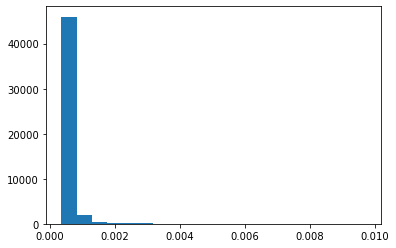

In [14]:
plt.hist(sample_weights, bins=20)

In [15]:
np.save('sample_weights_pressure_IPF.npy', sample_weights)

### Model

In [48]:
# ===== model parameters ======
mlp_unit1 = 128
mlp_unit2 = 128
mlp_unit3 = 64
mlp_unit4 = 64
mlp_unit5 = 32
mlp_unit6 = 32
mlp_unit7 = 16
mlp_unit8 = 16
dropout = 0.0
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 1000
BATCH = 512
opt_num = k
input_shape = train_X.shape[1:]

In [49]:
model = mlp_layer(input_shape=input_shape,
                   mlp_unit1=mlp_unit1,
                   mlp_unit2=mlp_unit2,
                   mlp_unit3=mlp_unit3,
                   mlp_unit4=mlp_unit4,
                   mlp_unit5=mlp_unit5,
                   mlp_unit6=mlp_unit6,
                   mlp_unit7=mlp_unit7,
                   mlp_unit8=mlp_unit8,
                   dropout=dropout,
                   masked_value=-1,
                   opt_num=opt_num
                  )
# model.summary()

In [50]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae']
             )

es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../../saved_models/pressure_all_weighted_IPF_95.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True,
                    )


model.fit(train_X, train_y,
          validation_data=(val_X, val_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc],
          sample_weight=sample_weights
         )

Epoch 1/1000
96/96 - 3s - loss: 9.3015e-06 - mae: 0.0903 - val_loss: 0.0205 - val_mae: 0.1040

Epoch 00001: val_mae improved from inf to 0.10397, saving model to ../../saved_models/pressure_all_weighted_IPF_95.h5
Epoch 2/1000
96/96 - 1s - loss: 3.7518e-06 - mae: 0.0571 - val_loss: 0.0089 - val_mae: 0.0611

Epoch 00002: val_mae improved from 0.10397 to 0.06111, saving model to ../../saved_models/pressure_all_weighted_IPF_95.h5
Epoch 3/1000
96/96 - 1s - loss: 2.7536e-06 - mae: 0.0490 - val_loss: 0.0086 - val_mae: 0.0603

Epoch 00003: val_mae improved from 0.06111 to 0.06032, saving model to ../../saved_models/pressure_all_weighted_IPF_95.h5
Epoch 4/1000
96/96 - 1s - loss: 2.5058e-06 - mae: 0.0466 - val_loss: 0.0082 - val_mae: 0.0600

Epoch 00004: val_mae improved from 0.06032 to 0.05999, saving model to ../../saved_models/pressure_all_weighted_IPF_95.h5
Epoch 5/1000
96/96 - 1s - loss: 2.3553e-06 - mae: 0.0450 - val_loss: 0.0070 - val_mae: 0.0540

Epoch 00005: val_mae improved from 0.0599


Epoch 00051: val_mae did not improve from 0.04317
Epoch 52/1000
96/96 - 1s - loss: 1.4300e-06 - mae: 0.0350 - val_loss: 0.0062 - val_mae: 0.0541

Epoch 00052: val_mae did not improve from 0.04317
Epoch 53/1000
96/96 - 1s - loss: 1.4024e-06 - mae: 0.0345 - val_loss: 0.0061 - val_mae: 0.0523

Epoch 00053: val_mae did not improve from 0.04317
Epoch 54/1000
96/96 - 1s - loss: 1.4266e-06 - mae: 0.0349 - val_loss: 0.0054 - val_mae: 0.0479

Epoch 00054: val_mae did not improve from 0.04317
Epoch 55/1000
96/96 - 1s - loss: 1.4078e-06 - mae: 0.0346 - val_loss: 0.0054 - val_mae: 0.0468

Epoch 00055: val_mae did not improve from 0.04317
Epoch 56/1000
96/96 - 1s - loss: 1.4081e-06 - mae: 0.0347 - val_loss: 0.0060 - val_mae: 0.0517

Epoch 00056: val_mae did not improve from 0.04317
Epoch 57/1000
96/96 - 1s - loss: 1.3913e-06 - mae: 0.0345 - val_loss: 0.0065 - val_mae: 0.0540

Epoch 00057: val_mae did not improve from 0.04317
Epoch 58/1000
96/96 - 1s - loss: 1.4014e-06 - mae: 0.0346 - val_loss: 0.0

96/96 - 1s - loss: 1.2881e-06 - mae: 0.0334 - val_loss: 0.0073 - val_mae: 0.0570

Epoch 00108: val_mae did not improve from 0.04317
Epoch 109/1000
96/96 - 1s - loss: 1.2753e-06 - mae: 0.0333 - val_loss: 0.0074 - val_mae: 0.0578

Epoch 00109: val_mae did not improve from 0.04317
Epoch 110/1000
96/96 - 1s - loss: 1.2819e-06 - mae: 0.0334 - val_loss: 0.0072 - val_mae: 0.0562

Epoch 00110: val_mae did not improve from 0.04317
Epoch 111/1000
96/96 - 1s - loss: 1.2994e-06 - mae: 0.0337 - val_loss: 0.0077 - val_mae: 0.0587

Epoch 00111: val_mae did not improve from 0.04317
Epoch 112/1000
96/96 - 1s - loss: 1.3010e-06 - mae: 0.0338 - val_loss: 0.0074 - val_mae: 0.0576

Epoch 00112: val_mae did not improve from 0.04317
Epoch 113/1000
96/96 - 1s - loss: 1.2963e-06 - mae: 0.0337 - val_loss: 0.0079 - val_mae: 0.0598

Epoch 00113: val_mae did not improve from 0.04317
Epoch 114/1000
96/96 - 1s - loss: 1.2961e-06 - mae: 0.0336 - val_loss: 0.0076 - val_mae: 0.0584

Epoch 00114: val_mae did not improve

96/96 - 1s - loss: 1.2034e-06 - mae: 0.0327 - val_loss: 0.0085 - val_mae: 0.0618

Epoch 00164: val_mae did not improve from 0.04317
Epoch 165/1000
96/96 - 1s - loss: 1.2022e-06 - mae: 0.0327 - val_loss: 0.0091 - val_mae: 0.0645

Epoch 00165: val_mae did not improve from 0.04317
Epoch 166/1000
96/96 - 1s - loss: 1.2084e-06 - mae: 0.0328 - val_loss: 0.0090 - val_mae: 0.0646

Epoch 00166: val_mae did not improve from 0.04317
Epoch 167/1000
96/96 - 1s - loss: 1.2216e-06 - mae: 0.0330 - val_loss: 0.0082 - val_mae: 0.0609

Epoch 00167: val_mae did not improve from 0.04317
Epoch 168/1000
96/96 - 1s - loss: 1.1967e-06 - mae: 0.0326 - val_loss: 0.0091 - val_mae: 0.0653

Epoch 00168: val_mae did not improve from 0.04317
Epoch 169/1000
96/96 - 1s - loss: 1.1958e-06 - mae: 0.0326 - val_loss: 0.0078 - val_mae: 0.0585

Epoch 00169: val_mae did not improve from 0.04317
Epoch 170/1000
96/96 - 1s - loss: 1.1940e-06 - mae: 0.0326 - val_loss: 0.0087 - val_mae: 0.0623

Epoch 00170: val_mae did not improve

96/96 - 1s - loss: 1.1307e-06 - mae: 0.0322 - val_loss: 0.0087 - val_mae: 0.0617

Epoch 00220: val_mae did not improve from 0.04317
Epoch 221/1000
96/96 - 1s - loss: 1.1268e-06 - mae: 0.0322 - val_loss: 0.0093 - val_mae: 0.0647

Epoch 00221: val_mae did not improve from 0.04317
Epoch 222/1000
96/96 - 1s - loss: 1.1055e-06 - mae: 0.0318 - val_loss: 0.0096 - val_mae: 0.0659

Epoch 00222: val_mae did not improve from 0.04317
Epoch 223/1000
96/96 - 1s - loss: 1.1145e-06 - mae: 0.0319 - val_loss: 0.0090 - val_mae: 0.0626

Epoch 00223: val_mae did not improve from 0.04317
Epoch 00223: early stopping
